In [100]:
import load_data 
import numpy as np
from feature_extraction import get_win_feats
from sklearn.ensemble import RandomForestRegressor
import pre_process
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from matplotlib import pyplot as plt

In [2]:
train,val = load_data.split_train_val("raw_training_data.mat",0.8)
reg = RandomForestRegressor(n_estimators=100,n_jobs=-1)
train_x, train_y = pre_process.filter_data(train[0][0]), train[1][0]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x, val_y = pre_process.filter_data(val[0][0]),val[1][0]
val_x = scaler.transform(val_x)
train_y_down = pre_process.downsample(int(25*train_y.shape[0]/1000),train_y)
val_y_down = pre_process.downsample(int(25*val_y.shape[0]/1000),val_y)

In [3]:
feature_train = get_win_feats.get_windowed_feats(train_x,1000,80,40)
feature_val = get_win_feats.get_windowed_feats(val_x,1000,80,40)
reg.fit(feature_train,pre_process.downsample(feature_train.shape[0],train_y_down))
pred = reg.predict(feature_val)

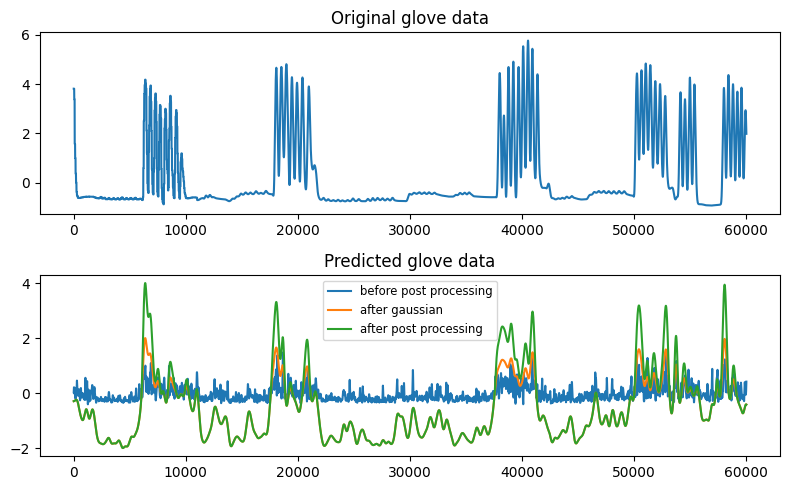

In [105]:
scaler = MinMaxScaler((-2,2))
# scaler = RobustScaler(unit_variance=True, quantile_range=(0.1, 0.9))
plt.figure(figsize=(8,5))
plt.subplot(211)
plt.plot(val_y [:,0])
plt.title('Original glove data')
plt.subplot(212)
plt.plot(pre_process.upsample(val_y.shape[0],pred)[:,0],label = 'before post processing')
pred_ = scaler.fit_transform(gaussian_filter1d(pred,sigma=4,axis=0))
plt.plot(pre_process.upsample(val_y.shape[0],pred_)[:,0],label = 'after gaussian')
# change the threshold
thre = 0
pred__ = pred_.copy()

for i in range(pred__.shape[0]):
    for j in range(pred__.shape[1]):
        if pred__[i,j]>thre:
            pred__[i,j] *= 2
        '''else: 
            pred__[i,j] = -0.5'''
        # elif 
            
        '''if pred__[i,j]>thre and pred__[i,j] * 3 < 5:
            pred__[i,j]*=4
        elif pred__[i,j] * 3 > 5:
            pred__[i,j] *= 2'''
            
'''if pred__[i,j]>=1.8:
            pred__[i,j]*=2
        elif pred__[i,j]>0 and  pred__[i,j]<1.8:
            pred__[i,j] *= 3'''
plt.plot(pre_process.upsample(val_y.shape[0],pred__)[:,0],label='after post processing')
plt.title('Predicted glove data')
plt.tight_layout()
plt.legend(fontsize='small')

In [104]:
corr = []
for i in range(5):
    corr.append(pearsonr(pre_process.upsample(val_y.shape[0],pred__)[:,i],val_y[:,i])[0])
    print(corr[i])
print('mean corr:',np.mean(corr))

0.6640524319197547
0.7358759145547569
0.29225354672486026
0.7440971071272785
-0.3369024173403682
mean corr: 0.41987531659725646
